In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# New section

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-04-02 16:30:10.598593: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 16:30:11.039081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/junwoo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TIME_INTERVAL = 1
NB_INPUT_FEATURES = 1
NB_LABEL_FEATURES = 9
WINDOW_WIDTH=256
SHIFT=32
SHUFFLE=True
MAX_EPOCHS = 10000
BATCH_SIZE=256
PATIENCE=250
alphas = [0.001, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 1.999]

In [3]:
#random.seed(38)
#strandom.seed(38)

In [4]:
N=10000
T=WINDOW_WIDTH
L = None

In [5]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [6]:
"""
trajs_model, labels_model = models_phenom().multi_state(N=N,
                                                        L=L,
                                                        T=T,
                                                        alphas=[0.85, 1.15],  # Fixed alpha for each state
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                        M=[[0.7, 0.3], [0.3, 0.7]]
                                                       )
"""

'\ntrajs_model, labels_model = models_phenom().multi_state(N=N,\n                                                        L=L,\n                                                        T=T,\n                                                        alphas=[0.85, 1.15],  # Fixed alpha for each state\n                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state\n                                                        M=[[0.7, 0.3], [0.3, 0.7]]\n                                                       )\n'

In [7]:
train_input = []
train_label = []
val_input = []
val_label = []
for n_label in range(NB_LABEL_FEATURES):
    alpha = [alphas[n_label], alphas[n_label]] 
    print(n_label)
    print(alpha)
    trajs_model, labels_model = models_phenom().multi_state(N=N,
                                                            L=L,
                                                            T=T,
                                                            alphas=alpha,  # Fixed alpha for each state
                                                            Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                            M=[[1.0, 0.0], [0.0, 1.0]]
                                                           )
    for n_traj in range(N):
        """
        xs = trajs_model[:, n_traj, 0]
        ys = trajs_model[:, n_traj, 1]
        xs = (xs - np.mean(xs)) / np.std(xs)
        ys = (ys - np.mean(ys)) / np.std(ys)
        if xs[0] > 0:
            xs = -xs
        if ys[0] > 0:
            ys = -ys

        freq_x = np.fft.fftfreq(xs.shape[-1])
        sp_x_real = abs(np.fft.fft(xs).real)
        sp_x_imag = abs(np.fft.fft(xs).imag)

        freq_y = np.fft.fftfreq(ys.shape[-1])
        sp_y_real = abs(np.fft.fft(ys).real)
        sp_y_imag = abs(np.fft.fft(ys).imag)   

        concat_arr_x = np.array([xs, freq_x, sp_x_real, sp_x_imag]).T
        concat_arr_y = np.array([ys, freq_y, sp_y_real, sp_y_imag]).T
        """
        xs = trajs_model[:, n_traj, 0]
        xs1 = (xs[:int(0.5*len(xs))] - np.mean(xs[:int(0.5*len(xs))])) / np.std(xs[:int(0.5*len(xs))])
        xs2 = (xs[int(0.5*len(xs)):] - np.mean(xs[int(0.5*len(xs)):])) / np.std(xs[int(0.5*len(xs)):])
        xs1 = np.cumsum(abs(uncumulate(xs1))) / (WINDOW_WIDTH/2)
        xs2 = np.cumsum(abs(uncumulate(xs2))) / (WINDOW_WIDTH/2)
        concat_xs = np.stack((xs1, xs2)).reshape(-1)
        #xs = (xs - np.mean(xs)) / np.std(xs)
        #xs = np.cumsum(abs(uncumulate(xs))) / WINDOW_WIDTH
        ys = trajs_model[:, n_traj, 1]
        ys1 = (ys[:int(0.5*len(ys))] - np.mean(ys[:int(0.5*len(ys))])) / np.std(ys[:int(0.5*len(ys))])
        ys2 = (ys[int(0.5*len(ys)):] - np.mean(ys[int(0.5*len(ys)):])) / np.std(ys[int(0.5*len(ys)):])
        ys1 = np.cumsum(abs(uncumulate(ys1))) / (WINDOW_WIDTH/2)
        ys2 = np.cumsum(abs(uncumulate(ys2))) / (WINDOW_WIDTH/2)
        concat_ys = np.stack((ys1, ys2)).reshape(-1)
        #ys = (ys - np.mean(ys)) / np.std(ys)
        #ys = np.cumsum(abs(uncumulate(ys))) / WINDOW_WIDTH



        if n_traj < (N * 0.8):
            train_input.append(concat_xs)
            train_input.append(concat_ys)
            train_label.append(n_label)
            train_label.append(n_label)
        else:
            val_input.append(concat_xs)
            val_input.append(concat_ys)
            val_label.append(n_label)
            val_label.append(n_label)
        
train_input = np.array(train_input)
train_label = np.array(train_label, dtype=np.int8).reshape(-1, 1)
val_input = np.array(val_input)
val_label = np.array(val_label, dtype=np.int8).reshape(-1, 1)
train_shuffle_index = np.arange(train_input.shape[0])
val_shuffle_index = np.arange(val_input.shape[0])
np.random.shuffle(train_shuffle_index)
np.random.shuffle(val_shuffle_index)
train_input = train_input[train_shuffle_index]
train_label = train_label[train_shuffle_index]
val_input = val_input[val_shuffle_index]
val_label = val_label[val_shuffle_index]

0
[0.001, 0.001]
1
[0.25, 0.25]
2
[0.5, 0.5]
3
[0.75, 0.75]
4
[1.0, 1.0]
5
[1.25, 1.25]
6
[1.5, 1.5]
7
[1.75, 1.75]
8
[1.999, 1.999]


In [ ]:
"""
K_bound = [1e-12, 1000000.0]
alpha_bound = [0, 1.999]
cp_seqs = []
non_cp_seqs = []
cp_alphasets = []
while len(cp_seqs) < 100:
    Ts = [WINDOW_WIDTH*2]
    alphas_copy = alphas.copy()
    T = int(np.random.choice(Ts, 1, replace=False)[0])
    alpha1, alpha2 = np.random.choice(alphas_copy, 2, replace=False)
    trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                            L=None,
                                                            T=T,
                                                            alphas=[alpha1, alpha2],  # Fixed alpha for each state
                                                            Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                            M=[[0.999, 0.001], [0.001, 0.999]]
                                                           )
    changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
    for i in range(len(changepoints)-1):
        cp = changepoints[i]
        if int(WINDOW_WIDTH/2) < cp < len(trajs_model[:, 0, :]) - int(WINDOW_WIDTH/2):
            cp_alphaset = [alphas_cp[i], alphas_cp[i+1]]
            change_point_containing_seq = trajs_model[:, 0, :][cp - int(WINDOW_WIDTH/2) : cp + int(WINDOW_WIDTH/2)]
            for _ in range(1000):
                flag = 1
                non_cp = np.random.randint(0 + int(WINDOW_WIDTH/2), T - int(WINDOW_WIDTH/2))
                non_cp_range = np.arange(non_cp - int(WINDOW_WIDTH/2), non_cp + int(WINDOW_WIDTH/2))
                for all_cps in changepoints:
                    if all_cps not in non_cp_range:
                        flag *= 1
                    else:
                        flag *= 0
                if flag == 1:
                    non_change_point_containing_seq = trajs_model[:, 0, :][non_cp - int(WINDOW_WIDTH/2) : non_cp + int(WINDOW_WIDTH/2)]

                    for index, seqxy in enumerate([[change_point_containing_seq[:, 0], change_point_containing_seq[:, 1]],
                                  [non_change_point_containing_seq[:, 0], non_change_point_containing_seq[:, 1]]]):
                        xs = seqxy[0]
                        xs1 = (xs[:int(0.5*len(xs))] - np.mean(xs[:int(0.5*len(xs))])) / np.std(xs[:int(0.5*len(xs))])
                        xs2 = (xs[int(0.5*len(xs)):] - np.mean(xs[int(0.5*len(xs)):])) / np.std(xs[int(0.5*len(xs)):])
                        xs1 = np.cumsum(abs(uncumulate(xs1))) / (WINDOW_WIDTH/2)
                        xs2 = np.cumsum(abs(uncumulate(xs2))) / (WINDOW_WIDTH/2)
                        concat_xs = np.stack((xs1, xs2)).reshape(-1)
                        
                        #ys = seqxy[1]
                        #ys = (ys - np.mean(ys)) / np.std(ys)
                        #ys = np.cumsum(abs(uncumulate(ys))) / WINDOW_WIDTH

                        if index == 0:
                            cp_seqs.append(concat_xs)
                            cp_alphasets.append(cp_alphaset)
                            #cp_seqs.append(ys)
                        else:
                            non_cp_seqs.append(concat_xs)
                            #non_cp_seqs.append(ys)
                    break
    if len(cp_seqs)%100 == 0: print(len(cp_seqs), len(non_cp_seqs))
"""

In [48]:
K_bound = [1e-12, 1000000.0]
alpha_bound = [0, 1.999]
cp_seqs = []
non_cp_seqs = []
cp_alphasets = []
non_cp_alphasets = []
while len(cp_seqs) < 100:
    Ts = [WINDOW_WIDTH]
    alphas_copy = alphas.copy()
    T = int(np.random.choice(Ts, 1, replace=False)[0])
    alpha1, alpha2 = np.random.choice(alphas_copy, 2, replace=False)
    trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                            L=None,
                                                            T=T,
                                                            alphas=[alpha1, alpha2],  # Fixed alpha for each state
                                                            Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                            M=[[0.999, 0.001], [0.001, 0.999]]
                                                           )
    changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
    for i in range(len(changepoints)-1):
        cp = changepoints[i]
        if int(WINDOW_WIDTH/4) < cp < len(trajs_model[:, 0, :]) - int(WINDOW_WIDTH/4):
            cp_alphaset = [alphas_cp[i], alphas_cp[i+1]]
            print(cp_alphaset, cp)
            change_point_containing_seq = trajs_model[:, 0, :][cp - int(WINDOW_WIDTH/4) : cp + int(WINDOW_WIDTH/4)]


            mono_alpha = [alpha1, alpha2][np.random.randint(2)]
            mono_trajs_model, mono_labels_model = models_phenom().multi_state(N=2,
                                                            L=None,
                                                            T=WINDOW_WIDTH,
                                                            alphas=[mono_alpha, mono_alpha],  # Fixed alpha for each state
                                                            Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                            M=[[1.0, 0.0], [0.0, 1.0]]
                                                           )

            non_change_point_containing_seq = mono_trajs_model[:, 0, :]
            for index, seqxy in enumerate([[change_point_containing_seq[:, 0], change_point_containing_seq[:, 1]],
                                           [non_change_point_containing_seq[:, 0], non_change_point_containing_seq[:, 1]]]):
                xs = seqxy[0]
                xs1 = (xs[:int(0.5*len(xs))] - np.mean(xs[:int(0.5*len(xs))])) / np.std(xs[:int(0.5*len(xs))])
                xs2 = (xs[int(0.5*len(xs)):] - np.mean(xs[int(0.5*len(xs)):])) / np.std(xs[int(0.5*len(xs)):])
                if index == 0:
                    xs1 = np.cumsum(abs(uncumulate(xs1))) / (WINDOW_WIDTH/2)
                    xs2 = np.cumsum(abs(uncumulate(xs2))) / (WINDOW_WIDTH/2)

                    ## interpolate x2
                    xs1 = np.insert(xs1, -1, xs1[-1])
                    left_ = xs1[:-1]
                    right_ = xs1[1:]
                    interpolate_arr = (left_ + right_) / 2
                    new_xs1 = []
                    for xval, inter_xval in zip(xs1[:-1], interpolate_arr):
                        new_xs1.append(xval)
                        new_xs1.append(inter_xval)
                    new_xs1 = np.array(new_xs1)

                    xs2 = np.insert(xs2, -1, xs2[-1])
                    left_ = xs2[:-1]
                    right_ = xs2[1:]
                    interpolate_arr = (left_ + right_) / 2
                    new_xs2 = []
                    for xval, inter_xval in zip(xs2[:-1], interpolate_arr):
                        new_xs2.append(xval)
                        new_xs2.append(inter_xval)
                    new_xs2 = np.array(new_xs2)
                    xs1 = new_xs1
                    xs2 = new_xs2
                else:
                    xs1 = np.cumsum(abs(uncumulate(xs1))) / (WINDOW_WIDTH/2)
                    xs2 = np.cumsum(abs(uncumulate(xs2))) / (WINDOW_WIDTH/2)
                concat_xs = np.stack((xs1, xs2)).reshape(-1)
                
                #ys = seqxy[1]
                #ys = (ys - np.mean(ys)) / np.std(ys)
                #ys = np.cumsum(abs(uncumulate(ys))) / WINDOW_WIDTH
                
                if index == 0:
                    cp_seqs.append(concat_xs)
                    cp_alphasets.append(cp_alphaset)
                    #cp_seqs.append(ys)
                else:
                    non_cp_seqs.append(concat_xs)
                    non_cp_alphasets.append(mono_alpha)
                    #non_cp_seqs.append(ys)
    if len(cp_seqs)%100 == 0: print(len(cp_seqs), len(non_cp_seqs))

[0.25, 0.5] 105
[1.75, 1.5] 85
[0.5, 0.25] 155
[1.25, 1.999] 98
[0.001, 1.75] 76
[0.75, 0.25] 83
[1.75, 0.5] 178
[0.75, 0.25] 73
[1.0, 1.75] 151
[1.75, 0.75] 118
[0.25, 1.0] 74
[0.25, 0.5] 166
[1.75, 0.25] 77
[1.25, 1.0] 107
[0.5, 1.999] 189
[1.75, 0.75] 77
[1.25, 0.75] 162
[0.5, 1.25] 85
[1.999, 0.5] 146
[1.0, 1.75] 162
[1.999, 0.5] 80
[0.001, 1.75] 88
[1.5, 1.0] 174
[0.5, 1.75] 65
[1.0, 1.25] 96
[1.999, 0.25] 181
[1.25, 0.001] 158
[1.5, 1.75] 80
[0.25, 1.75] 118
[1.5, 1.75] 107
[1.75, 1.5] 146
[1.5, 1.75] 174
[1.5, 1.75] 174
[0.75, 0.25] 69
[0.25, 1.5] 136
[0.5, 1.75] 163
[0.5, 1.25] 123
[1.75, 0.75] 91
[1.5, 0.75] 101
[1.25, 1.75] 72
[0.25, 1.999] 77
[0.001, 1.0] 132
[1.999, 1.5] 181
[1.5, 1.75] 126
[1.0, 0.75] 114
[0.001, 0.25] 121
[0.25, 0.001] 125
[0.25, 1.0] 179
[0.25, 0.75] 121
[1.5, 0.25] 87
[1.75, 0.75] 128
[0.5, 0.25] 86
[0.001, 1.75] 92
[0.5, 0.25] 158
[1.25, 0.5] 84
[1.5, 0.25] 116
[0.75, 0.5] 155
[0.5, 0.75] 175
[0.25, 1.75] 74
[1.25, 0.5] 79
[1.999, 0.5] 161
[1.0, 0.001]

In [9]:
print(train_input.shape, train_label.shape, val_input.shape, val_label.shape)
train_input = train_input.reshape((-1, WINDOW_WIDTH, NB_INPUT_FEATURES))
val_input = val_input.reshape((-1, WINDOW_WIDTH, NB_INPUT_FEATURES))
print(train_input.shape, train_label.shape, val_input.shape, val_label.shape)

(144000, 256) (144000, 1) (36000, 256) (36000, 1)
(144000, 256, 1) (144000, 1) (36000, 256, 1) (36000, 1)


[1.75, 0.75] 1.75


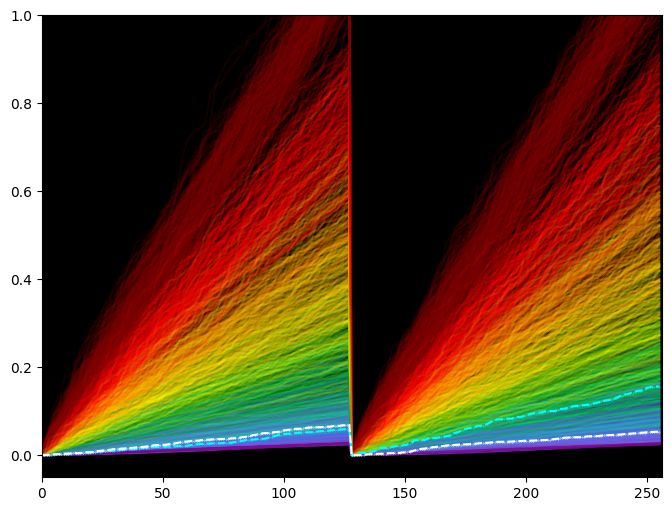

In [61]:
ax = plt.axes()
ax.set_facecolor("k")
color_set = ['maroon', 'red', 'orange', 'yellow', 'green', 'springgreen', 'royalblue', 'mediumslateblue', 'purple']
myrange = np.arange(9, 10)
for i in range(0, 2000):
    color = color_set[train_label[i][0]]
    plt.plot(train_input[i], label=f'{train_label[i]}', color=color, alpha=0.15, zorder=-1)
for cp_seq, changepoint_alpha, non_cp_seq, non_cp_alpha in zip(cp_seqs[myrange[0]:myrange[0]+1],
                                                               cp_alphasets[myrange[0]:myrange[0]+1],
                                                               non_cp_seqs[myrange[0]:myrange[0]+1],
                                                               non_cp_alphasets[myrange[0]:myrange[0]+1]):
    print(changepoint_alpha, non_cp_alpha)
    plt.plot(cp_seq, color='aqua', alpha=1.0, marker='o', linestyle='dashed', markersize=0.3)
    plt.plot(non_cp_seq, color='white', alpha=1.0, marker='o', linestyle='dashed', markersize=0.3)
plt.xlim([0.0, WINDOW_WIDTH])
plt.ylim([-0.05, 1.0])
plt.savefig(f'./{WINDOW_WIDTH}.png', transparent=True)

In [40]:
train_tf = tf.data.Dataset.from_tensor_slices((train_input, train_label)).batch(BATCH_SIZE)
val_tf = tf.data.Dataset.from_tensor_slices((val_input, val_label)).batch(BATCH_SIZE)
print(train_tf)
print(val_tf)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int8, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int8, name=None))>


In [ ]:
"""
changepoints, alphas, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
print(f'change points: {changepoints}, {changepoints.shape}')
print(f'alphas: {alphas}, {alphas.shape}')
print(f'Ds: {Ds}, {Ds.shape}')
print(f'State_nums: {state_num}, {state_num.shape}')

weight_for_0 = (1 / (T-len(changepoints))) * (T / 2.0)
weight_for_1 = (1 / len(changepoints) * (T / 2.0))
CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}
print(CLASS_WEIGHT)
"""

In [ ]:
"""
xs = trajs_model[:, 0, 0]
ys = trajs_model[:, 0, 1]
pos = np.array([xs, ys]).T
trajectory_object = TrajectoryObj(index=0)
for t, (x, y) in enumerate(pos):
    trajectory_object.add_trajectory_position(t, x, y, 0.0)
label_list = read_andi2_trajectory_label([Ds, alphas, state_num, changepoints])
trajectory_label = label_list[0]

print(xs[:10])
print(ys[:10])
"""

In [ ]:
"""
trajectory_list = read_trajectory(f'data/trajs_fov_0.csv')
label_list = read_andi2_trajectory_label(f'data/traj_labs_fov_0.txt')
trajectory_object = trajectory_list[0]
trajectory_label = label_list[0]
"""

In [ ]:
"""
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)
xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3].astype(int)
"""

In [ ]:
print(msd.shape, diff_coefs.shape, angles.shape, xs.shape, ys.shape, labeled_diff_coefs.shape, labeled_alphas.shape, labeled_states.shape, labeled_cps.shape)

In [ ]:
"""
#df = np.array([xs, ys, diff_coefs, msd, angles]).T
df = np.array([diff_coefs, msd, angles]).T
#df = pd.DataFrame(df, columns=['xs', 'ys', 'diff_coefs', 'msd', 'angles'])
df = pd.DataFrame(df, columns=['diff_coefs', 'msd', 'angles'])
target_df = np.array([labeled_cps]).T  # labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps
target_df = pd.DataFrame(target_df, columns=['cps'])  # 'lb_diff_coefs', 'alphas', 'states', 'cps'
"""

In [ ]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

target_train_df = target_df[0:int(n*0.7)]
target_val_df = target_df[int(n*0.7):int(n*0.9)]
target_test_df = target_df[int(n*0.9):]

In [ ]:
"""
train_mean = train_df.mean()
train_std = train_df.std()

for normallization_col in ['xs', 'ys']:
    train_df[normallization_col] = (train_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
    val_df[normallization_col] = (val_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
    test_df[normallization_col] = (test_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

print(train_df.head())
"""

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               target_train_df=target_train_df, target_val_df=target_val_df,
               target_test_df=target_test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = np.array(train_df).reshape(train_df.shape[0], NB_INPUT_FEATURES)
    self.val_df = np.array(val_df).reshape(val_df.shape[0], NB_INPUT_FEATURES)
    self.test_df = np.array(test_df).reshape(test_df.shape[0], NB_INPUT_FEATURES)

    self.target_train_df = np.zeros((train_df.shape[0], NB_LABEL_FEATURES))
    self.target_val_df = np.zeros((val_df.shape[0], NB_LABEL_FEATURES))
    self.target_test_df = np.zeros((test_df.shape[0], NB_LABEL_FEATURES))

    self.target_train_df = target_train_df
    self.target_val_df = target_val_df
    self.target_test_df = target_test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.shift = shift

    self.total_window_size = input_width

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_indices = self.input_indices[0:1]

    print('input_indices: ', self.input_indices)
    print('label_indices: ', self.label_indices)

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def normalization(inputs):
    normalization_base = tf.repeat(inputs[:,0:1,0:3], repeats=WINDOW_WIDTH, axis=1)
    empty_base = tf.zeros_like(normalization_base)
    normalization_base = tf.stack([normalization_base, empty_base], axis=2)
    normalization_base = tf.reshape(normalization_base, [-1, WINDOW_WIDTH, 6])[:,:,:5]
    return inputs - normalization_base

In [ ]:
def normalization(inputs):
    nb_normalize_features = 3
    normalization_base = tf.repeat(inputs[:,0:1,0:nb_normalize_features], repeats=WINDOW_WIDTH, axis=1)
    for _ in range(2):
        empty_base = tf.zeros_like(normalization_base)
        normalization_base = tf.stack([normalization_base, empty_base], axis=2)
        normalization_base = tf.reshape(normalization_base, [-1, WINDOW_WIDTH, empty_base.shape[2] * 2])
    normalization_base = tf.reshape(normalization_base, [-1, WINDOW_WIDTH, normalization_base.shape[2]])
    normalization_base = normalization_base[:,:,:NB_INPUT_FEATURES]
    return inputs - normalization_base

In [ ]:
def split_window(self, *args):
    inputs = args[0][:, self.input_slice, :]
    labels = args[1][:,:]

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, None])

    #inputs = normalization(inputs)

    inputs.set_shape([None, self.input_width, NB_INPUT_FEATURES])  # LSTM
    #inputs = tf.reshape(inputs, [-1, self.input_width, NB_INPUT_FEATURES, 1])  # Conv
    labels.set_shape([None, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='xs', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      print('pr', predictions.shape, n, label_col_index)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Frame')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data, targets):
    data = np.array(data, dtype=np.float32)
    targets = np.array(targets, dtype=np.int8)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        sampling_rate=1,
        shuffle=SHUFFLE,
        batch_size=BATCH_SIZE,)
    #ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.map(self.split_window)
    print(ds)
    return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
wide_window = WindowGenerator(
    input_width=WINDOW_WIDTH, shift=SHIFT)
print(wide_window)
for example_inputs, example_labels in wide_window.train.take(2):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    plt.figure()
    for i in range(2):
        print(alphas[int(example_labels[i][0])])
        plt.plot(np.arange(len(example_inputs[i, :, 0])), example_inputs[i, :, 0], label=f'{example_labels[i][0]}', alpha=0.7)
    plt.legend()
    plt.figure()
    for i in range(2):
        plt.scatter(example_inputs[i, :, 1], example_inputs[i, :, 2], label=f'{example_labels[i][0]}')
    plt.legend()
    plt.figure()
    for i in range(2):
        plt.scatter(example_inputs[i, :, 1], example_inputs[i, :, 3], label=f'{example_labels[i][0]}')
    plt.legend()

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df, self.target_train_df)

@property
def val(self):
  return self.make_dataset(self.val_df, self.target_val_df)

@property
def test(self):
  return self.make_dataset(self.test_df, self.target_test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [38]:
def compile_and_fit(model, train_tf, val_tf, patience=100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True,)
    """
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
    """
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy', dtype=None)]
                 ) 
    history = model.fit(x=train_tf,
                        validation_data=val_tf,
                        epochs=MAX_EPOCHS,
                        shuffle=True,
                        #class_weight=CLASS_WEIGHT,
                        callbacks=[early_stopping],
                        verbose=2)
    return history

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
#wide_window = WindowGenerator(
#    input_width=WINDOW_WIDTH, shift=SHIFT)

for example_inputs, example_labels in train_tf.take(5):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    plt.figure()
    print(alphas[int(example_labels[0])])
    plt.plot(np.arange(len(example_inputs[0, :, 0])), example_inputs[0, :, 0], label=f'{example_labels[0]}', alpha=0.7)
    plt.legend()

In [ ]:
%%time
residual_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(1024),
    #tf.keras.layers.LSTM(512),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Dense(512),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(NB_LABEL_FEATURES, 'softmax'),
])

history = compile_and_fit(residual_lstm, train_tf, val_tf, patience=PATIENCE)

Epoch 1/10000
563/563 - 50s - loss: 1.5335 - sparse_categorical_accuracy: 0.3467 - val_loss: 1.1739 - val_sparse_categorical_accuracy: 0.4407 - 50s/epoch - 89ms/step
Epoch 2/10000
563/563 - 49s - loss: 1.0604 - sparse_categorical_accuracy: 0.5841 - val_loss: 0.9767 - val_sparse_categorical_accuracy: 0.6258 - 49s/epoch - 87ms/step
Epoch 3/10000
563/563 - 49s - loss: 0.9665 - sparse_categorical_accuracy: 0.6326 - val_loss: 0.9206 - val_sparse_categorical_accuracy: 0.6434 - 49s/epoch - 87ms/step
Epoch 4/10000


In [ ]:
%%time
residual_lstm = tf.keras.Sequential([
    #tf.keras.layers.LSTM(512),
    #tf.keras.layers.LSTM(512),
    tf.keras.layers.Conv2D(filters=2048, kernel_size=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
    tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1), strides=(1, 1), padding='valid'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(2, 2), padding='same'),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.L2(0.01)),
    #tf.keras.layers.Dense(256),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, 'sigmoid'),
])

history = compile_and_fit(residual_lstm, wide_window, patience=PATIENCE)

In [ ]:
IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, return_dict=True)
print()

In [ ]:
def make_prediction_set(test_set, window_width):
    pred_set = []
    for i in range(len(test_set)):
        tmp = np.array(test_set[i:i+window_width])
        if len(tmp) == window_width:
            tmp = normalization(tmp.reshape(1, window_width, NB_INPUT_FEATURES))
            pred_set.append(tmp)
    return np.array(pred_set).reshape(len(pred_set), window_width, NB_INPUT_FEATURES)


In [ ]:
all_pred = make_prediction_set(df, WINDOW_WIDTH)
all_pred_result = residual_lstm.predict(all_pred)

print(all_pred.shape)
print(all_pred_result.shape, all_pred_result[:10])

In [ ]:
"""
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,2], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['states'], c='blue')
"""

print(changepoints)
print(np.where(np.round(all_pred_result[:,0]) >=1.0)[0] - int(WINDOW_WIDTH//2))
fig, axs = plt.subplots(T//500, 1, figsize=(12, 12))
for subplot_row in range(T//500):
    axs[subplot_row].plot(
        np.arange(min(1000, len(all_pred_result[:,0][subplot_row*500: subplot_row*500 + 500]))) + subplot_row*500,
        all_pred_result[:,0][subplot_row*500: subplot_row*500 + 500],
        c='red', alpha=0.5)
    axs[subplot_row].plot(
        np.arange(min(500, len(target_df['cps'][subplot_row*500: subplot_row*500 + 500]))) + subplot_row*500,
        target_df['cps'][subplot_row*500: subplot_row*500 + 500],
        c='blue', alpha=0.4)

In [ ]:
"""
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,2], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['states'], c='blue')
"""

print(changepoints)
print(np.where(np.round(all_pred_result[:,0]) >=1.0)[0] - int(WINDOW_WIDTH//2))
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
axs[0].plot(
        np.arange(len(all_pred_result[:,0][:500])),
        all_pred_result[:,0][:500],
        c='red', alpha=0.5)
axs[0].plot(
        np.arange(len(all_pred_result[:,0][:500])),
        target_df['cps'][:500],
        c='blue', alpha=0.4)

axs[1].plot(
        np.arange(len(all_pred_result[:,0][int(T*0.7):int(T*0.7) + 2000])),
        all_pred_result[:,0][int(T*0.7):int(T*0.7) + 2000],
        c='red', alpha=0.5)
axs[1].plot(
        np.arange(len(all_pred_result[:,0][int(T*0.7):int(T*0.7) + 2000])),
        target_df['cps'][int(T*0.7):int(T*0.7) + 2000],
        c='blue', alpha=0.4)

In [ ]:
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,0], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['lb_diff_coefs'], c='blue')

plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,1], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['alphas'], c='blue')

In [ ]:
trajectory_object = trajectory_list[12]
trajectory_label = label_list[12]
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)

xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]
xs -= xs[0]
ys -= ys[0]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3]

train_df = np.array([xs, ys, msd, diff_coefs, angles]).T
train_df = pd.DataFrame(train_df, columns=['xs', 'ys', 'msd', 'diff_coefs', 'angles'])
target_df = np.array([labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps]).T
target_df = pd.DataFrame(target_df, columns=['lb_diff_coefs', 'alphas', 'states', 'cps'])

test_ = make_prediction_set(train_df, WINDOW_WIDTH)
test_result = residual_lstm.predict(test_)

In [ ]:
plt.figure()
plt.plot(np.arange(test_result.shape[0]), test_result[:,0], c='red')
plt.plot(np.arange(target_df.shape[0]), target_df['lb_diff_coefs'], c='blue')

plt.figure()
plt.plot(np.arange(test_result.shape[0]), test_result[:,1], c='red')
plt.plot(np.arange(target_df.shape[0]), target_df['alphas'], c='blue')